This notebook compares different ways of treating missing data for different HRV features (namely RMSSD, SD1a and GI, but it should be easily modifiable to compare other features too!) 

The code uses a [specific branch of the Neurokit2 repository on my GitHub](https://github.com/danibene/NeuroKit/commit/8c6902918c008f4aff73148f59b4ed2163c144f7) and I didn't comment it very much, so feel free to ask me if you have any questions! 

A plot comparing the different methods on SD1a and GI can be found by scrolling down to the last cell of the notebook.

In [ ]:
# using relative path to load neurokit2
# since I'd like to load the version with my changes
import os
orig_dir = os.getcwd()
print(orig_dir)
new_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(new_dir)

In [3]:
print(os.getcwd())
os.chdir(new_dir)
print(os.getcwd())
import neurokit2 as nk
from neurokit2.signal import signal_distort
from neurokit2.ecg.ecg_simulate import _ecg_simulate_ecgsyn
from neurokit2.misc import find_outliers
from neurokit2.hrv.hrv_utils import _hrv_get_rri, _hrv_sanitize_input
from neurokit2.hrv import hrv_time, hrv_nonlinear
from neurokit2.hrv import hrv
from neurokit2.signal import signal_interpolate
from neurokit2.misc import NeuroKitWarning, find_successive_intervals

os.chdir(orig_dir)
print(os.getcwd())

/home/jovyan/docs/examples
/home/jovyan
/home/jovyan/docs/examples


In [4]:
# other imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# load real biosignal data
data = nk.data(dataset="bio_resting_8min_100hz")
# get ECG channel
ecg_data_all = data["ECG"]
# sampling rate in file name
sampling_rate = 100
# take 5 minutes of the recording
num_seconds = 300

In [6]:
# set the seed for the random number generator
# used for distorting the ECG data
seed = 42
np.random.seed(seed)

In [7]:
# select a 5 minute segment
first_sample = np.random.randint(0, len(ecg_data_all) - num_seconds * sampling_rate)
last_sample = first_sample + num_seconds * sampling_rate
ecg_clean = np.array(ecg_data_all[first_sample : last_sample])

In [8]:
# distort the ECG data
noise_shape = "laplace"
noise_amplitude = 0.5
noise_frequency = 5
powerline_amplitude = 0
powerline_frequency = 50
artifacts_amplitude = 2
artifacts_number = int(np.floor((len(ecg_clean) / sampling_rate) / 5))
artifacts_frequency = 10
linear_drift = False

# create a copy of ECG data
ecg_noise = ecg_clean.copy()
ecg_noise = signal_distort(
    ecg_noise,
    sampling_rate=sampling_rate,
    noise_shape=noise_shape,
    noise_amplitude=noise_amplitude,
    noise_frequency=noise_frequency,
    powerline_amplitude=powerline_amplitude,
    powerline_frequency=powerline_frequency,
    artifacts_amplitude=artifacts_amplitude,
    artifacts_frequency=artifacts_frequency,
    artifacts_number=artifacts_number,
    linear_drift=linear_drift,
    random_state=seed,
    silent=False
)

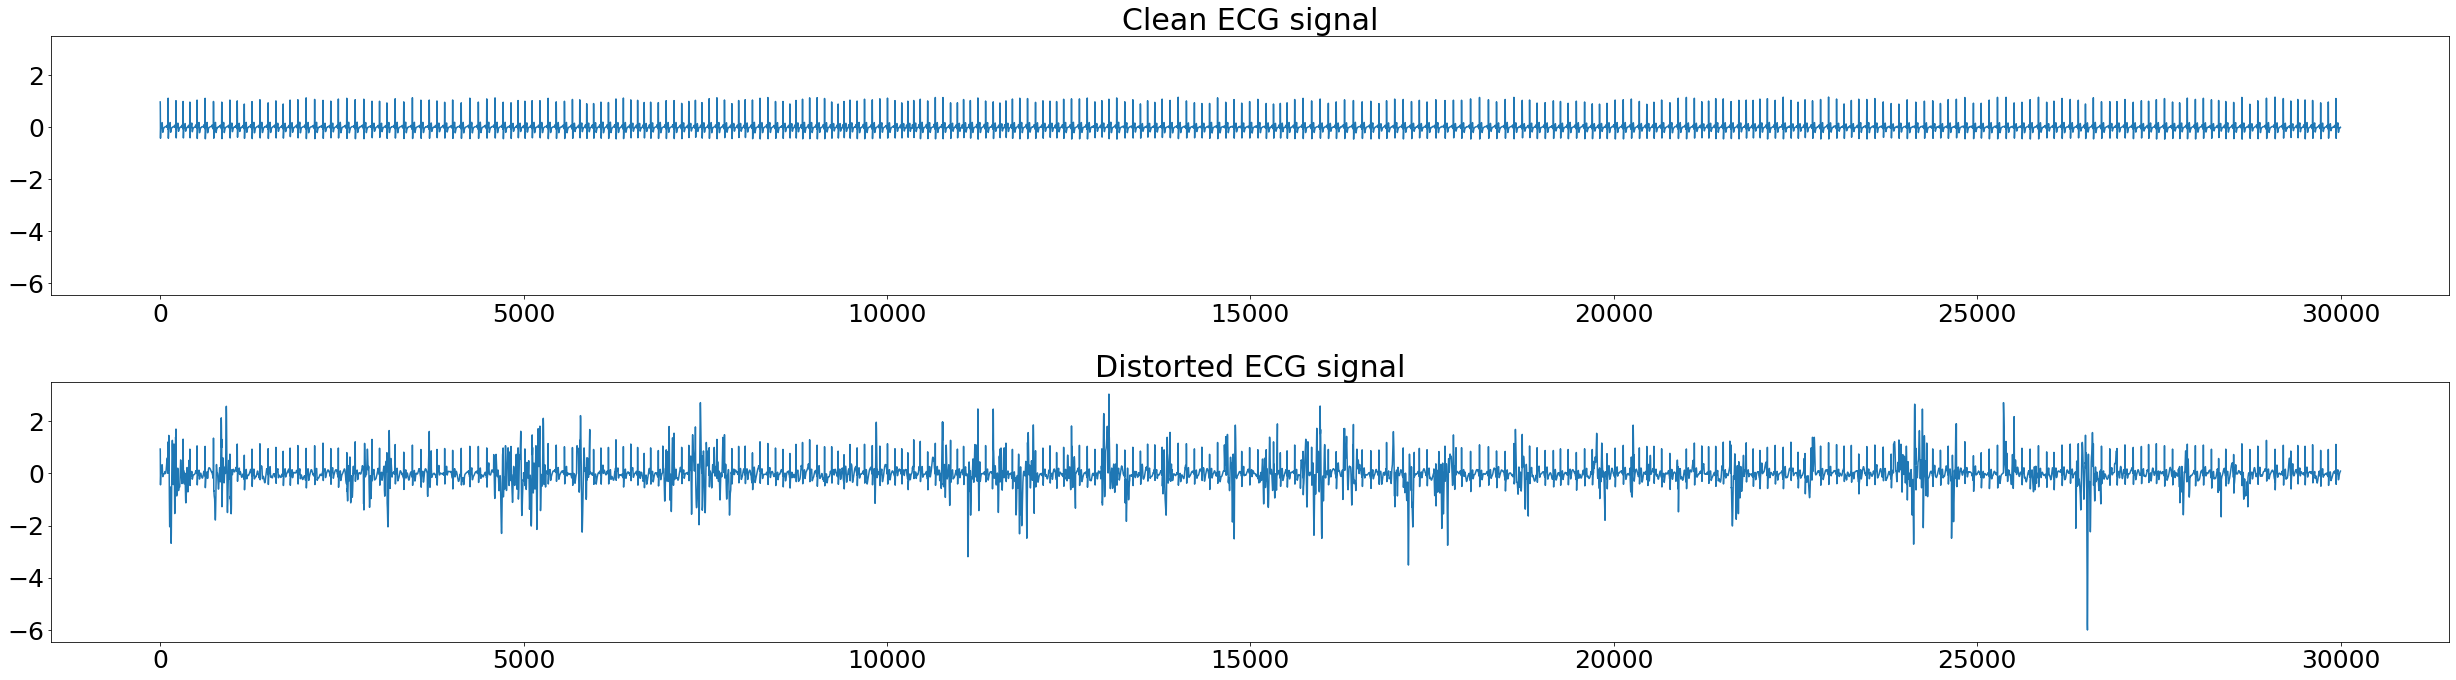

In [9]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=25)

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.plot(ecg_clean)
ax1.set_title("Clean ECG signal")
ax2.plot(ecg_noise)
ax2.set_title("Distorted ECG signal")
plt.tight_layout()
fig.show()

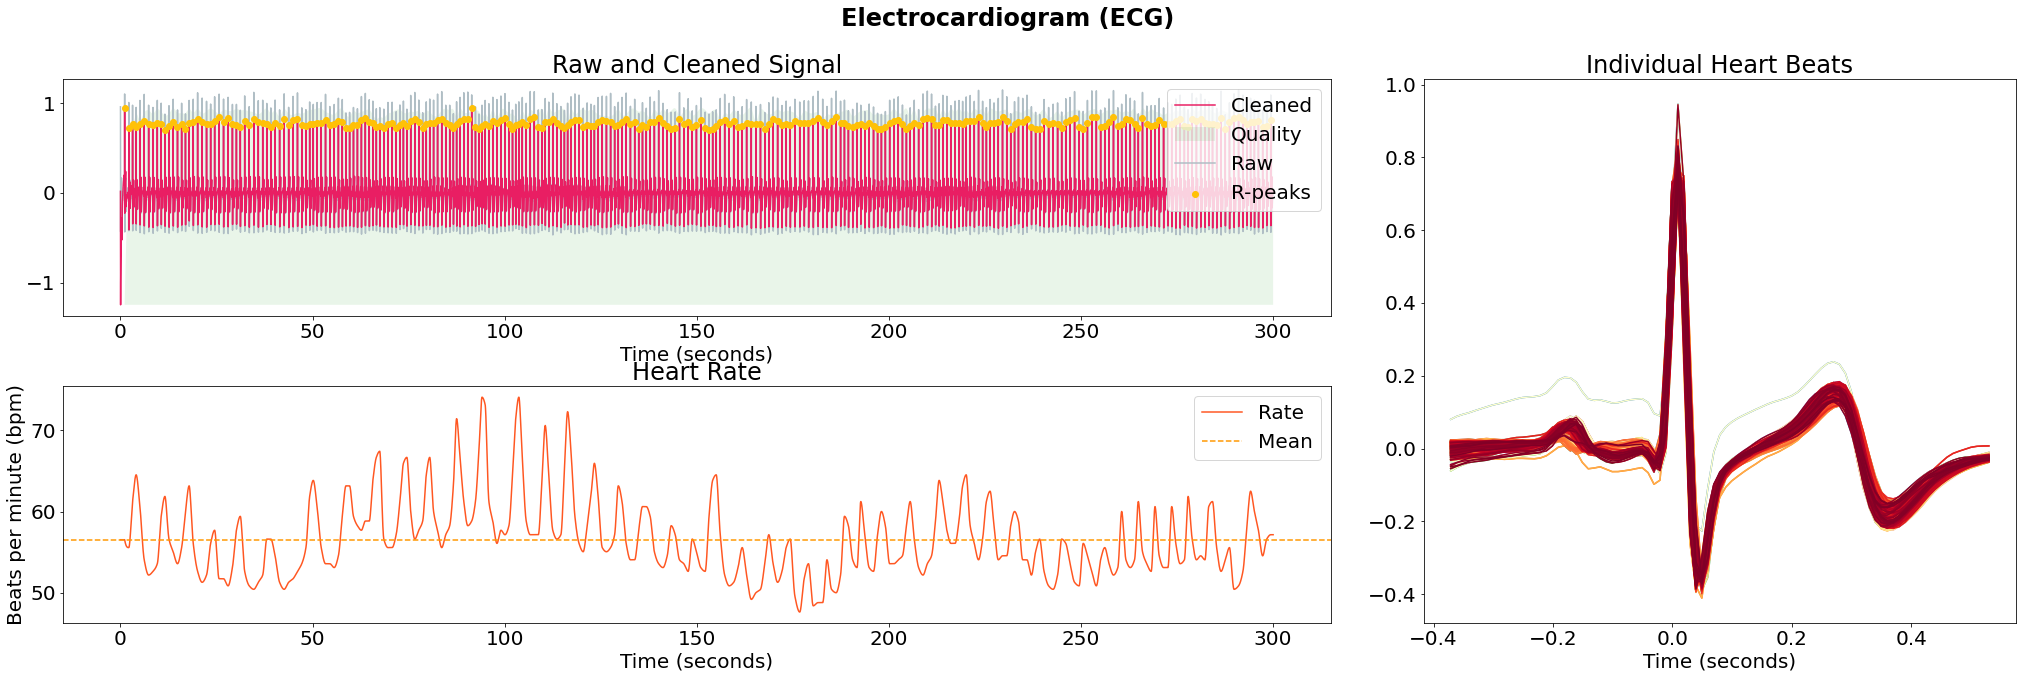

In [10]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=20)

# Process it
signals_clean, info_clean = nk.ecg_process(ecg_clean, sampling_rate=sampling_rate)

# Visualise the processing
fig = nk.ecg_plot(signals_clean, sampling_rate=sampling_rate)

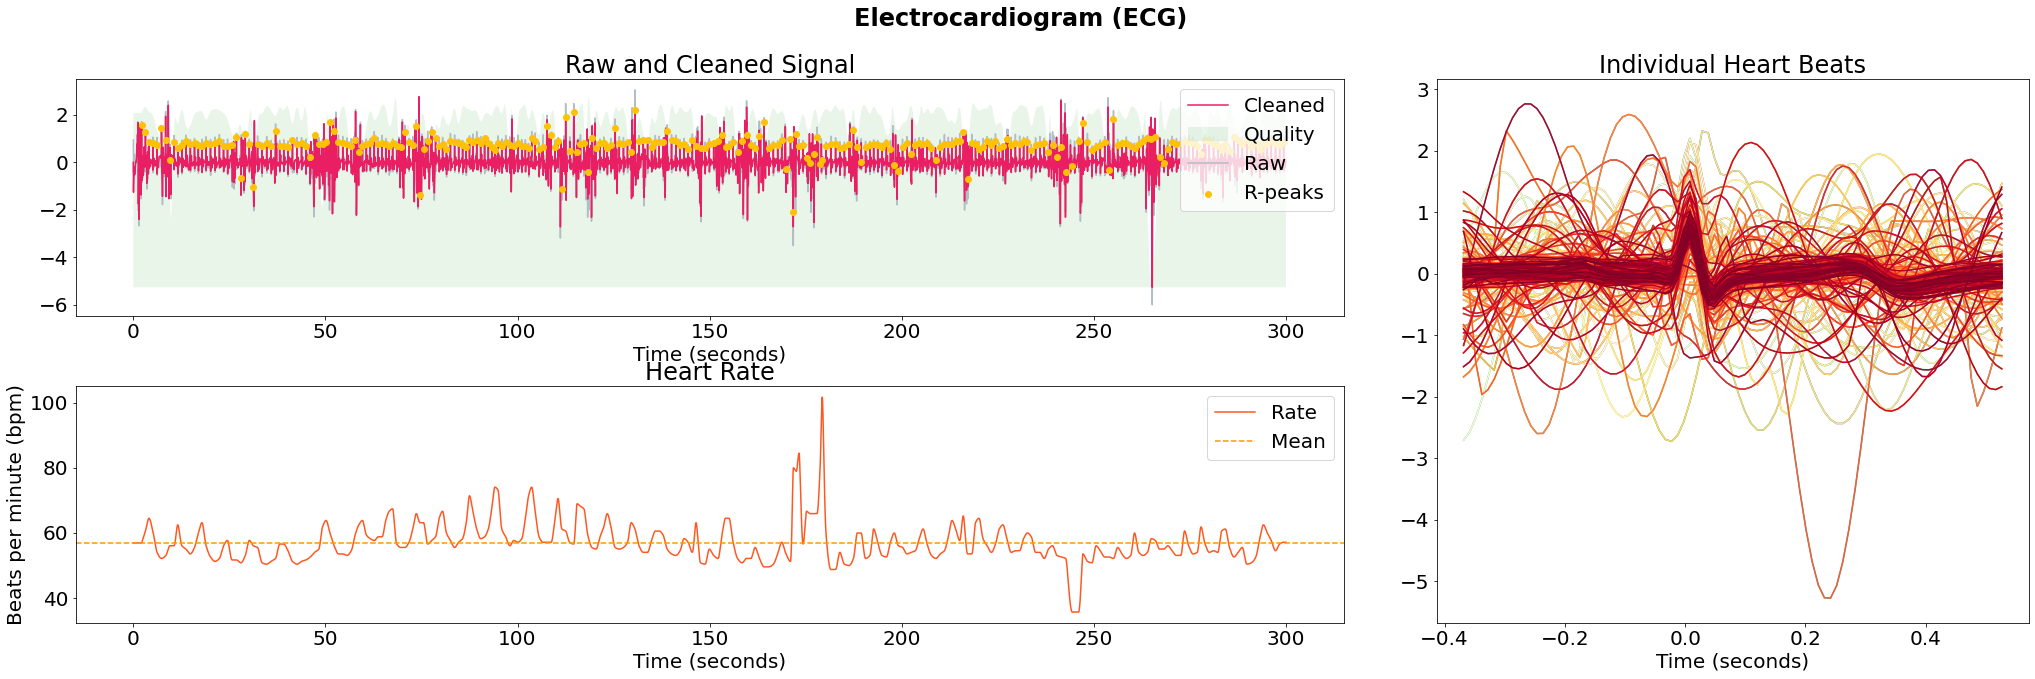

In [11]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=20)

# Process it
signals_noise, info_noise = nk.ecg_process(ecg_noise, sampling_rate=sampling_rate)

# Visualise the processing
fig = nk.ecg_plot(signals_noise, sampling_rate=sampling_rate)

In [12]:
peaks = np.array(signals_noise["ECG_R_Peaks"])

# Sanitize input
peaks = _hrv_sanitize_input(peaks)
if isinstance(peaks, tuple):  # Detect actual sampling rate
    peaks, sampling_rate = peaks[0], peaks[1]

# Compute R-R intervals (also referred to as NN) in milliseconds
rri, _ = _hrv_get_rri(peaks, sampling_rate=sampling_rate, interpolate=False)
rri_time = np.cumsum(rri) / 1000

In [13]:
def ecg_to_cleaned_rri(ecg, sampling_rate=1000, exclude=0, **kwargs):
    # Process it
    signals, info = nk.ecg_process(ecg, sampling_rate=sampling_rate)
    peaks = np.array(signals["ECG_R_Peaks"])

    # Sanitize input
    peaks = _hrv_sanitize_input(peaks)
    if isinstance(peaks, tuple):  # Detect actual sampling rate
        peaks, sampling_rate = peaks[0], peaks[1]

    # Compute R-R intervals (also referred to as NN) in milliseconds
    rri, _ = _hrv_get_rri(peaks, sampling_rate=sampling_rate, interpolate=False)
    rri_time = peaks[1:] / sampling_rate

    if exclude > 0:
        # Remove outliers
        rri_time = rri_time[np.invert(find_outliers(rri, exclude=exclude, **kwargs))]
        rri = rri[np.invert(find_outliers(rri, exclude=exclude, **kwargs))]
    return rri, rri_time

In [14]:
def find_diff_from_ref(
    x_values,
    y_values,
    x_values_ref,
    y_values_ref,
    method="quadratic",
    ms_threshold=None
):

    if len(x_values) != len(y_values):
        raise ValueError(
            "Error: find_diff_from_ref(): x_values and y_values must be of the same length."
        )

    if len(x_values_ref) != len(y_values_ref):
        raise ValueError(
            "Error: find_diff_from_ref(): x_values_ref and y_values_ref must be of the same length."
        )

    interpolation_function = scipy.interpolate.interp1d(
        x_values,
        y_values,
        kind=method,
        bounds_error=False,
        fill_value=([y_values[0]], [y_values[-1]]),
    )
    
    if ms_threshold is None:
        return np.array(y_values_ref - interpolation_function(x_values_ref))
    else:
        return np.array(
            abs(y_values_ref - interpolation_function(x_values_ref)) > ms_threshold
        )

In [15]:
rri_clean, rri_time_clean = ecg_to_cleaned_rri(
    ecg_clean, sampling_rate=sampling_rate, exclude=0
)
rri_noise_before_removal, rri_time_noise_before_removal = ecg_to_cleaned_rri(
    ecg_noise, sampling_rate=sampling_rate, exclude=0
)
rri_noise_after_removal, rri_time_noise_after_removal = ecg_to_cleaned_rri(
    ecg_noise, sampling_rate=sampling_rate, exclude=0.2
)

In [16]:
# instead of automatic detection
# simulate manually cleaned RRI
# where all RRI that differ from the clean RRI 
# by more than a threshold are removed

ms_threshold = 25
diff_indices = find_diff_from_ref(
    rri_time_clean,
    rri_clean,
    rri_time_noise_before_removal,
    rri_noise_before_removal,
    ms_threshold=ms_threshold,
)

rri_noise_after_removal = rri_noise_before_removal[np.invert(diff_indices)]
rri_time_noise_after_removal = rri_time_noise_before_removal[np.invert(diff_indices)]

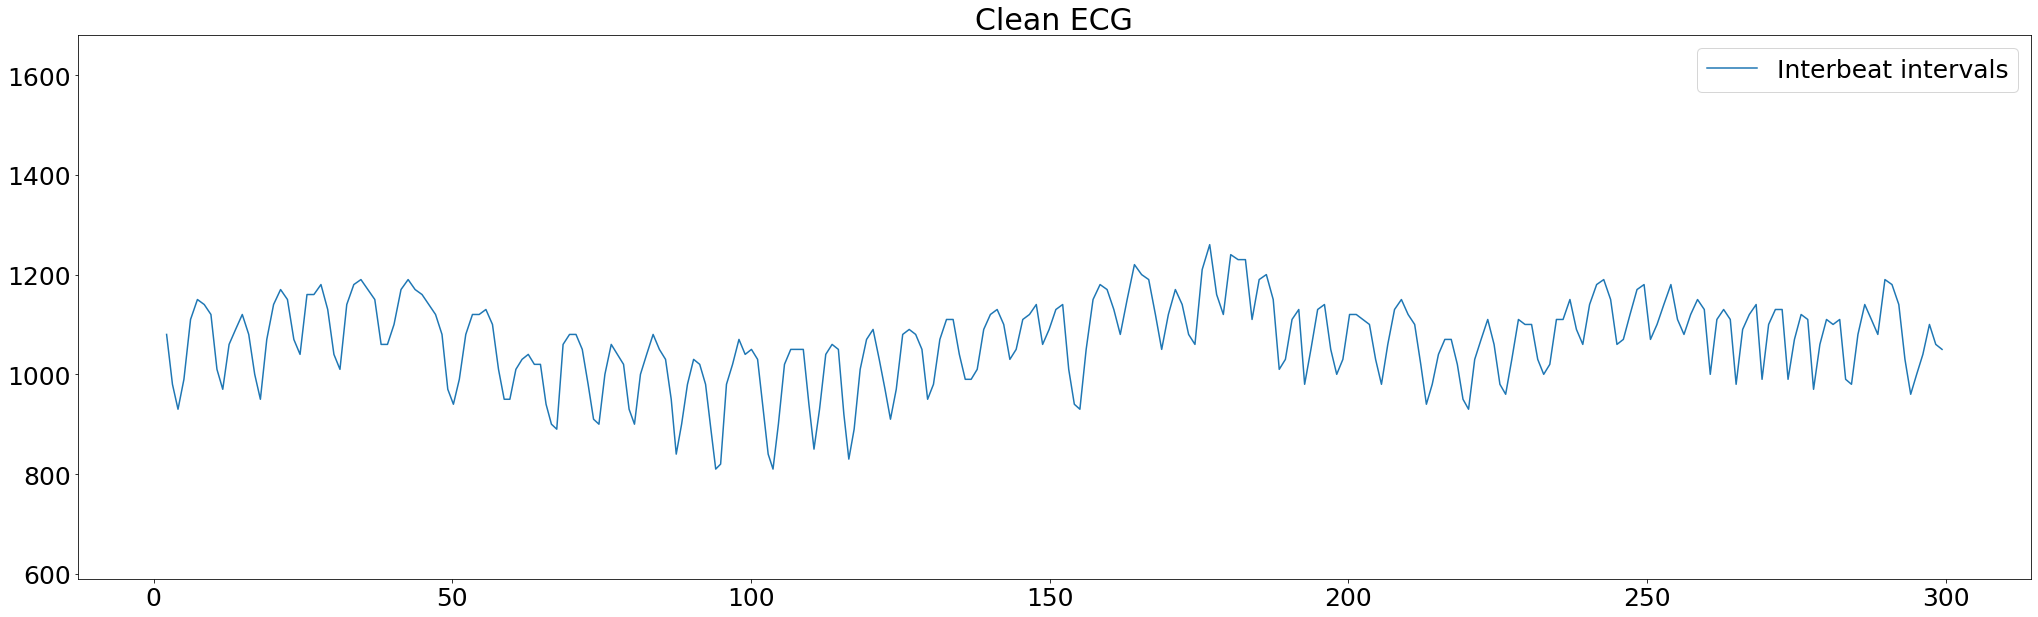

MAE before removal: 22.247427113873513


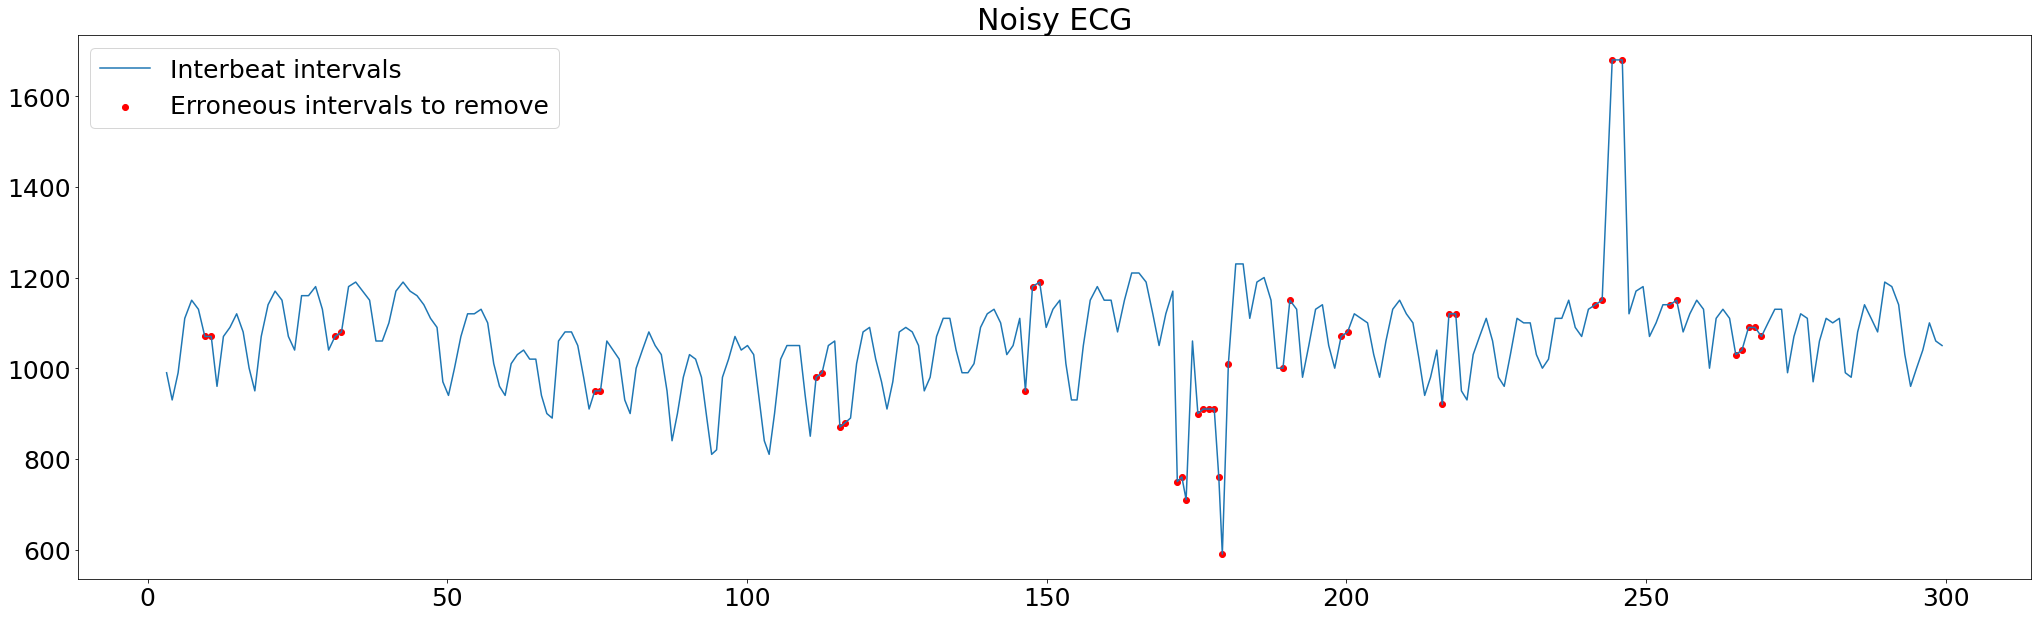

MAE after removal: 7.715646108562648


In [17]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=25)

plt.figure()
plt.plot(rri_time_clean, rri_clean)
ax = plt.gca()
ax.set_ylim([np.min(rri_noise_before_removal), np.max(rri_noise_before_removal)])
plt.title("Clean ECG")
plt.legend(["Interbeat intervals"])
plt.show()

mae_before_removal = np.mean(
    np.abs(
        find_diff_from_ref(
            x_values=rri_time_noise_before_removal,
            y_values=rri_noise_before_removal,
            x_values_ref=rri_time_clean,
            y_values_ref=rri_clean,
        )
    )
)
print("MAE before removal: " + str(mae_before_removal))

plt.figure()
plt.plot(rri_time_noise_before_removal, rri_noise_before_removal)
plt.scatter(
    rri_time_noise_before_removal[diff_indices],
    rri_noise_before_removal[diff_indices],
    c="red"
)
plt.legend(["Interbeat intervals","Erroneous intervals to remove"])
plt.title("Noisy ECG")
plt.show()

mae_after_removal = np.mean(
    np.abs(
        find_diff_from_ref(
            x_values=rri_time_noise_after_removal,
            y_values=rri_noise_after_removal,
            x_values_ref=rri_time_clean,
            y_values_ref=rri_clean
        )
    )
)
print("MAE after removal: " + str(mae_after_removal))

In [18]:
def resample_with_uneven_times(
    x_old, y_old, sampling_rate=1000, method="quadratic", **kwargs
):
    start_sample_new = np.floor(sampling_rate * x_old[0])
    end_sample_new = np.ceil(sampling_rate * x_old[-1])
    x_new = np.arange(start_sample_new, end_sample_new) / sampling_rate
    y_new = signal_interpolate(x_old, y_old, x_new=x_new, **kwargs)
    return x_new, y_new

In [55]:
import numpy as np


def find_successive_intervals(intervals, intervals_time=None, thresh_unequal=2, n_diff=1):
    """Identify successive intervals
    Identification of intervals that are consecutive
    (e.g. in case of missing data).
    Parameters
    ----------
    intervals : list or ndarray
        Intervals, e.g. breath-to-breath (BBI) or rpeak-to-rpeak (RRI)
    intervals_time : list or ndarray, optional
        Time points corresponding to intervals, in seconds.
    thresh_unequal : int or float, optional
        Threshold at which the difference between time points is considered to
        be unequal to the interval, in milliseconds.
    n_diff: int, optional
        The number of times values are differenced.
        Can be used to check which values are valid for the n-th difference
        assuming successive intervals.
    Returns
    ----------
    successive_intervals: ndarray
        A list of True/False with True being the successive intervals.
    Example
    ----------
    >>> import neurokit2 as nk
    >>> rri = [400, 500, 700, 800, 900]
    >>> rri_time = [0.7,  1.2,  2.5, 3.3, 4.2]
    >>> successive_intervals = nk.find_successive_intervals(rri, rri_time)
    >>> successive_intervals
    array([ True, False,  True,  True])
    >>> rri = [400, 500, np.nan, 700, 800, 900]
    >>> successive_intervals = find_successive_intervals(rri)
    >>> successive_intervals
    array([ True, False, False,  True,  True])
    """

    # Convert to numpy array
    intervals = np.array(intervals)

    if intervals_time is None:
        intervals_time = np.nancumsum(intervals / 1000)
    else:
        intervals_time = np.array(intervals_time)

    intervals_time[np.isnan(intervals)] = np.nan

    diff_intervals_time_ms = np.diff(intervals_time, n=n_diff) * 1000

    abs_error_intervals_ref_time = abs(diff_intervals_time_ms - np.diff(intervals[1:], n=n_diff - 1))

    successive_intervals = abs_error_intervals_ref_time <= thresh_unequal

    return np.array(successive_intervals)

In [92]:
def rri_to_peak_time(rri, rri_time=None):
    if rri_time is None:
        first_peak_time = 0
        peak_time = np.insert(arr=first_peak_time + np.cumsum(rri)/1000, obj=0, values=first_peak_time)
    else:
        first_peak_time = rri_time[0] - rri[0] / 1000
        peak_time = np.insert(arr=rri_time, obj=0, values=first_peak_time)
    return peak_time

In [105]:
def interpolate_on_time(rri_time, rri, median_rri=750):
    # Interpolate values
    non_successive_indices = np.invert(find_successive_intervals(intervals=rri, intervals_time=rri_time))
    flip_indices = np.flip(np.where(non_successive_indices)[0])
    flip_indices_rri_time = flip_indices + 1
    n_nan = np.round((np.diff(rri_time)[flip_indices]*1000)/median_rri)
    for i in range(len(flip_indices_rri_time)):
        rri_time = np.insert(arr = rri_time, obj = flip_indices_rri_time[i], values = [np.nan]*int(n_nan[i]))
    rri_time = pd.Series(rri_time).interpolate(method="quadratic").values
    first_peak_time = rri_time[0] - rri[0] / 1000
    peak_time = np.insert(arr=rri_time, obj=0, values=first_peak_time)
    rri = np.diff(peak_time)*1000
    return rri_time, rri

In [104]:
rri_time_noise_after_removal_med_ontime

array([ 990.        ,  930.        ,  872.90104876, ..., 1100.        ,
       1060.        , 1050.        ])

In [63]:
rri_noise_after_removal = rri_noise_before_removal[np.invert(diff_indices)]
rri_time_noise_after_removal = rri_time_noise_before_removal[np.invert(diff_indices)]
rri = rri_noise_after_removal
rri_time = rri_time_noise_after_removal

In [81]:
median_rri = 900
non_successive_indices = [np.invert(find_successive_intervals(intervals=rri, intervals_time=rri_time))]
np.round((np.diff(rri_time)[np.invert(find_successive_intervals(intervals=rri, intervals_time=rri_time))]*1000)/median_rri)

array([3., 4., 3., 3., 3., 5., 4., 8., 4., 4., 5., 8., 4., 7.])

In [49]:
def _period_to_location(period, sampling_rate=1000, first_location=0):
    location = np.cumsum(period * sampling_rate)
    location = location - (location[0] - first_location)
    return location.astype(int)

def something_else(peaks, interval, sampling_rate=1000):
    # Interpolate values
    outliers = np.isnan(peaks)
    outliers_loc = np.where(outliers)[0]
    interval = pd.Series(interval).interpolate().values
    peaks_corrected = _period_to_location(interval, sampling_rate, first_location=peaks[0])
    peaks = np.insert(peaks, outliers_loc, peaks_corrected[outliers_loc + np.arange(len(outliers_loc))])
    return peaks

In [50]:
test_rri = np.array([900,800,700,600,700,np.nan,900])
test_rri_time = test_rri/1000

In [54]:
rri_to_peak_times(test_rri,test_rri_time)

array([0. , 0.9, 0.8, 0.7, 0.6, 0.7, nan, 0.9])

In [31]:
pd.Series(test_rri_time).interpolate(method="quadratic").values

array([0.9       , 0.8       , 0.7       , 0.6       , 0.7       ,
       0.81267388, 0.9       ])

In [27]:
interpolate_missing_peaks(test_rri_time, test_rri)

array([9.0e-01, 8.0e-01, 7.0e-01, 6.0e-01, 7.0e-01, 3.6e+06,     nan,
       9.0e-01])

In [95]:
median_rri

1070.0

In [106]:
# clean ECG HRV features
out_clean = hrv(
    rri_clean, rri_time=rri_time_clean, data_format="rri", check_successive=False
)

# keep erroneous intervals from noisy ECG
out_before_removal = hrv(
    rri_noise_before_removal,
    rri_time=rri_time_noise_before_removal,
    data_format="rri",
    check_successive=False,
)

# remove erroneous intervals from noisy ECG
out_include = hrv(rri_noise_after_removal, data_format="rri", check_successive=False)

# exclude non-successive intervals when computing certain features (e.g. SD1a and GI)
out_exclude = hrv(
    rri_noise_after_removal,
    rri_time=rri_time_noise_after_removal,
    data_format="rri",
    check_successive=True,
)

# get median RR and convert to Hz for interpolation
median_rri = np.median(rri_noise_after_removal)
decimals_sampling_rate = 3
median_rri_sampling_rate = np.round(
    (1 / median_rri) * 1000, decimals=decimals_sampling_rate
)
print("Median RRI (ms) = " + str(int(median_rri)))
median_bpm = np.round(60000 / median_rri)
print("Beats per minute from median RRI = " + str(int(median_bpm)))
print("Frequency from median RRI (Hz) = " + str(median_rri_sampling_rate))
(
    rri_time_noise_after_removal_med,
    rri_noise_after_removal_med,
) = resample_with_uneven_times(
    rri_time_noise_after_removal,
    rri_noise_after_removal,
    sampling_rate=median_rri_sampling_rate,
)
out_interpl_med = hrv(
    rri_noise_after_removal_med,
    rri_time_noise_after_removal_med,
    data_format="rri",
    check_successive=False,
)

(
    rri_time_noise_after_removal_med_ontime,
    rri_noise_after_removal_med_ontime,
) = interpolate_on_time(
    rri_time_noise_after_removal,
    rri_noise_after_removal,
    median_rri=median_rri,
)

out_interpl_med_ontime = hrv(
    rri_noise_after_removal_med_ontime,
    rri_time_noise_after_removal_med_ontime,
    data_format="rri",
    check_successive=False,
)


# Fixed value (2 Hz) interpolation
(
    rri_time_noise_after_removal_2hz,
    rri_noise_after_removal_2hz,
) = resample_with_uneven_times(
    rri_time_noise_after_removal, rri_noise_after_removal, sampling_rate=2
)

out_interpl_2hz = hrv(
    rri_noise_after_removal_2hz,
    rri_time_noise_after_removal_2hz,
    data_format="rri",
    check_successive=False,
)

Median RRI (ms) = 1070
Beats per minute from median RRI = 56
Frequency from median RRI (Hz) = 0.935


In [ ]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=25)
plt.figure()
plt.plot(rri_time_clean, rri_clean)
plt.plot(rri_time_noise_before_removal, rri_noise_before_removal)
plt.plot(rri_time_noise_after_removal_med_ontime, rri_noise_after_removal_med_ontime)
plt.scatter(
    rri_time_noise_before_removal[diff_indices],
    rri_noise_before_removal[diff_indices],
    c="red"
)
plt.legend(["Clean", "Before removal", "On time interpolated", "Erroneous intervals to remove"])
plt.title("Noisy ECG")
plt.show()

HRV_RMSSD
Clean data
65.14544167805275
Noisy data
Before outlier removal
93.03885079904586
Including non-successive intervals
69.06518659932803
Excluding non-successive intervals
63.813195295372175
Median-RR based interpolation
61.11323726183558
Median-RR based interpolation: on time
85.63856568069184
2 Hz interpolation
30.57746290384713
[ 42.81713103   6.01691357  -2.04503392  -6.18954191  31.45749491
 -53.06277444]


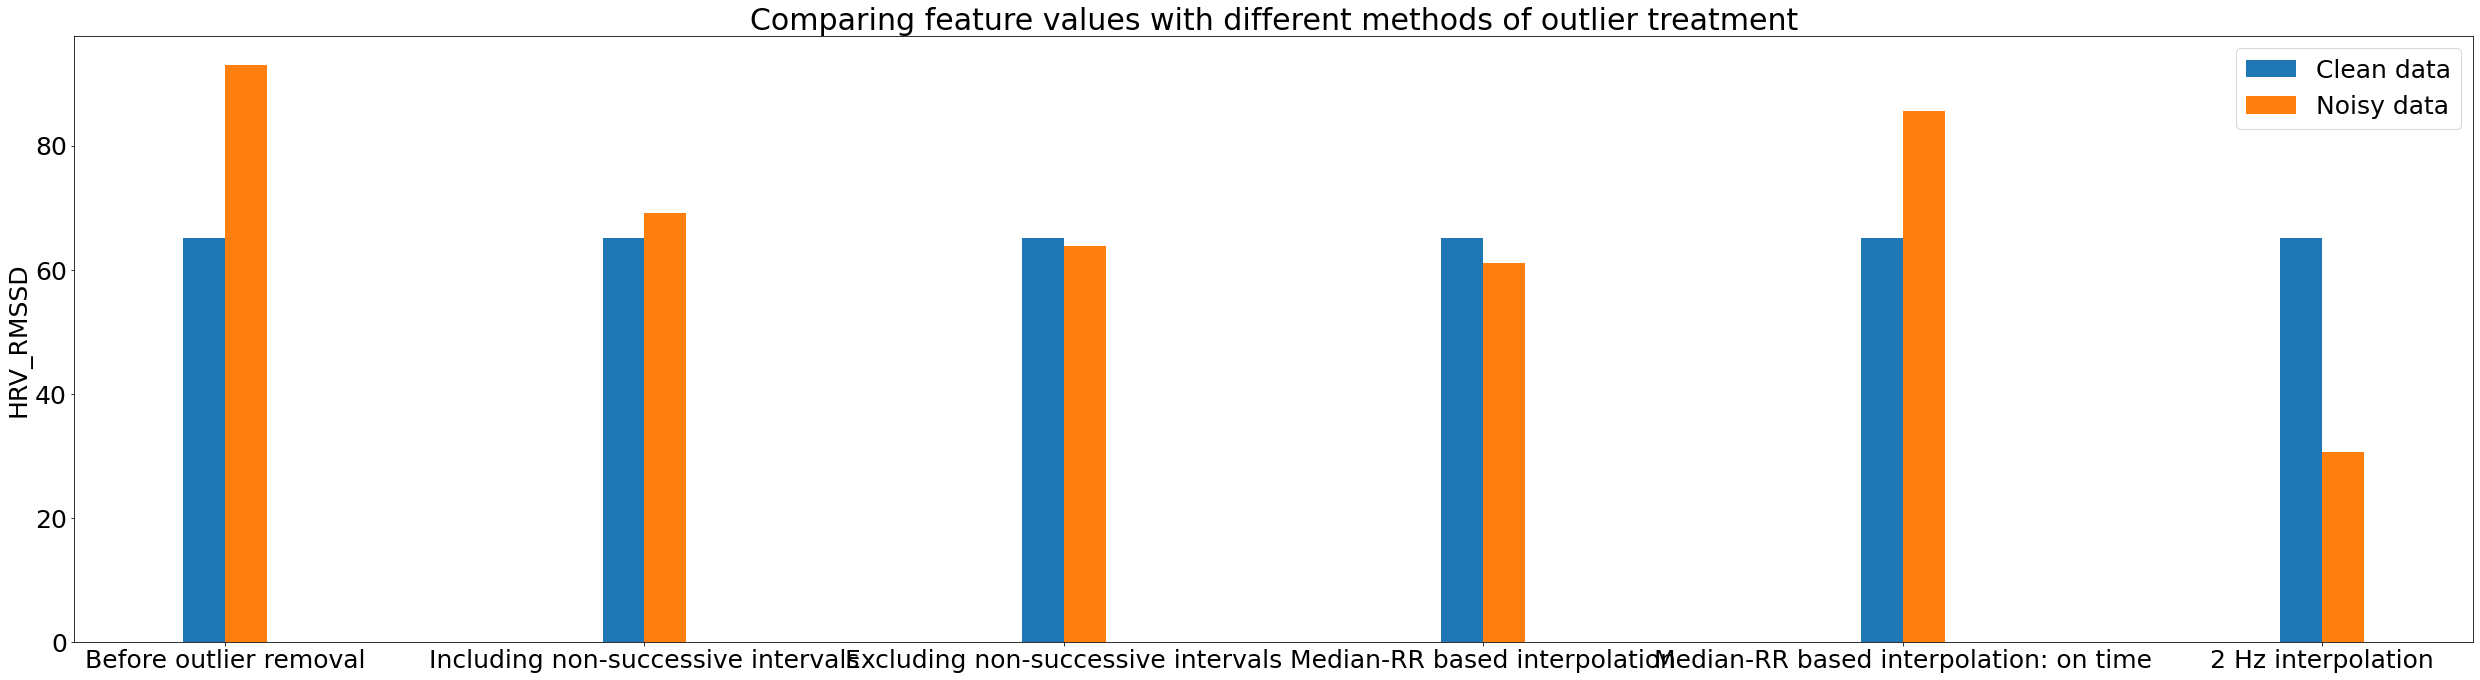

HRV_SD1a
Clean data
32.75027702419156
Noisy data
Before outlier removal
46.016301459374155
Including non-successive intervals
34.09622121665728
Excluding non-successive intervals
32.4379750018743
Median-RR based interpolation
30.72366871307641
Median-RR based interpolation: on time
42.52145247335924
2 Hz interpolation
15.474906113106476
[ 40.5066022    4.1097185   -0.9535859   -6.18806464  29.83539786
 -52.74877797]


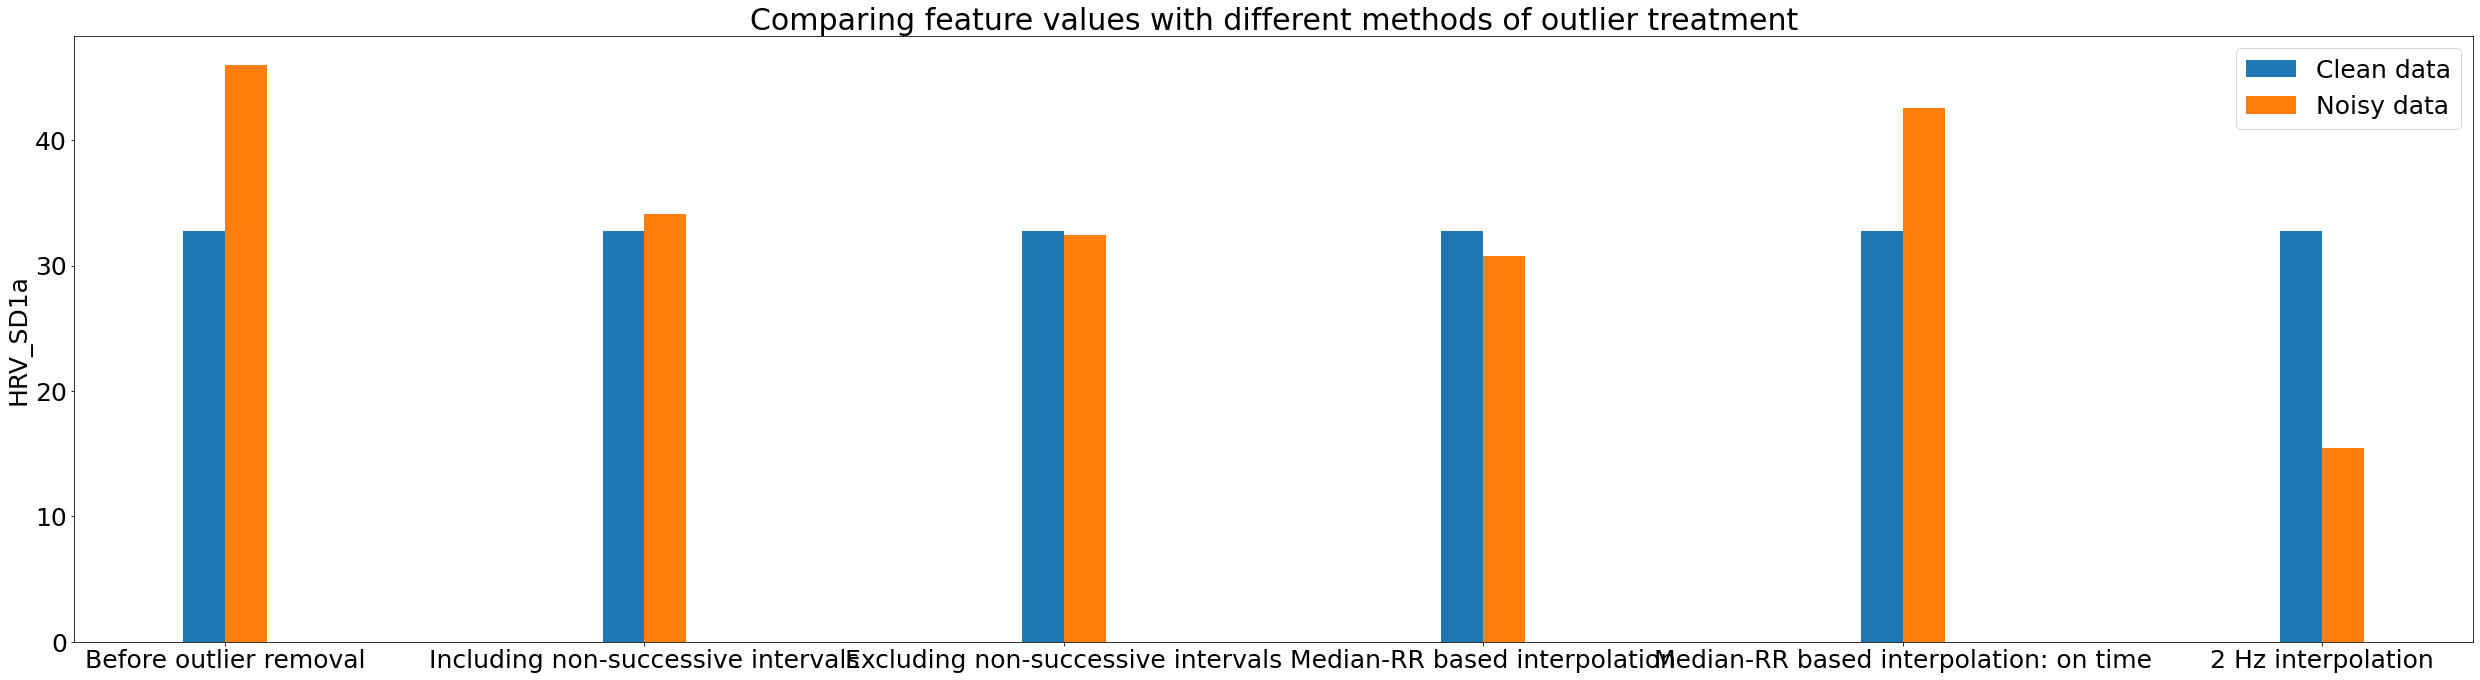

HRV_GI
Clean data
49.89802855200544
Noisy data
Before outlier removal
50.17584994138334
Including non-successive intervals
50.22865853658538
Excluding non-successive intervals
49.0924805531547
Median-RR based interpolation
50.25069937816248
Median-RR based interpolation: on time
50.150846845727294
2 Hz interpolation
50.20097310715783
[ 0.55677829  0.66261132 -1.61438843  0.70678309  0.5066699   0.6071273 ]


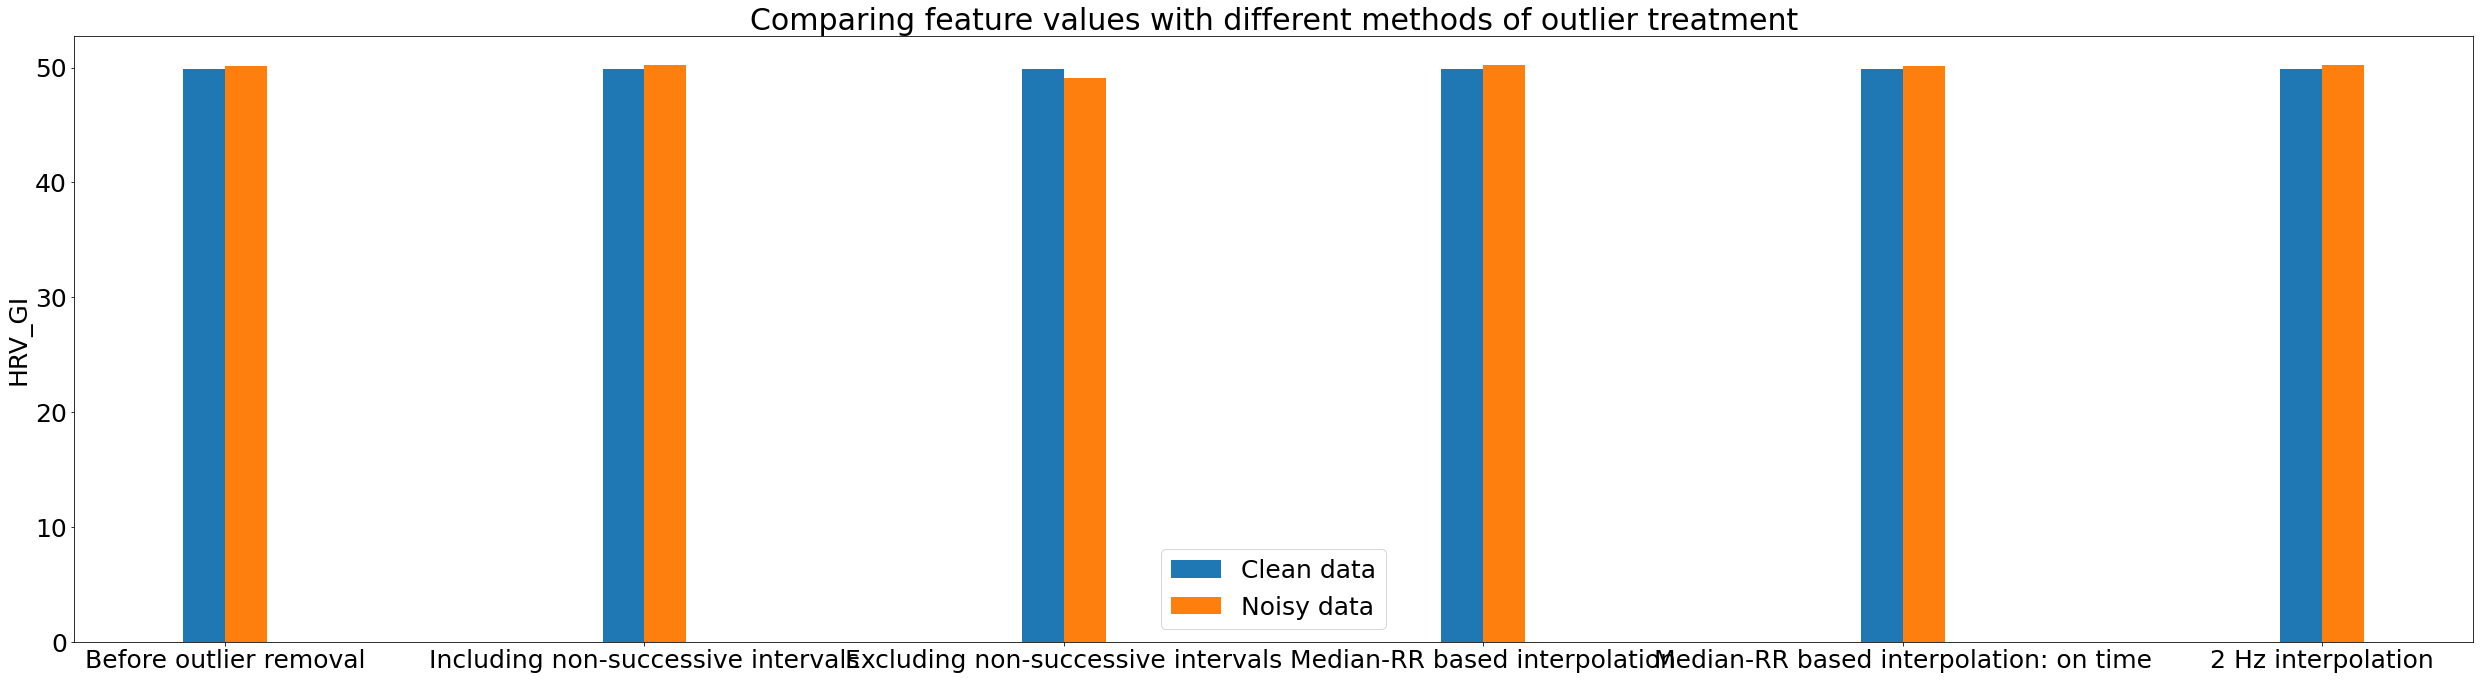

In [107]:
plt.rcParams["figure.figsize"] = (35, 10)
plt.rc("font", size=25)

# feats_to_comp = ["HRV_MedianNN","HRV_MadNN","HRV_RMSSD","HRV_SDNNI1","HRV_HFn","HRV_SD1a","HRV_GI"]
feats_to_comp = ["HRV_RMSSD","HRV_SD1a", "HRV_GI"]
for feat_to_comp in feats_to_comp:
    print(feat_to_comp)
    labels = [
        "Before outlier removal",
        "Including non-successive intervals",
        "Excluding non-successive intervals",
        "Median-RR based interpolation",
        "Median-RR based interpolation: on time",
        "2 Hz interpolation",
    ]
    out_feat = [
        float(out_before_removal[feat_to_comp]),
        float(out_include[feat_to_comp]),
        float(out_exclude[feat_to_comp]),
        float(out_interpl_med[feat_to_comp]),
        float(out_interpl_med_ontime[feat_to_comp]),
        float(out_interpl_2hz[feat_to_comp]),
    ]
    print("Clean data")
    print(float(out_clean[feat_to_comp]))
    print("Noisy data")
    for i in range(len(labels)):
        print(labels[i])
        print(out_feat[i])
    ground_truth = [float(out_clean[feat_to_comp])] * len(out_feat)

    perc_change = ((np.array(out_feat) - ground_truth) / ground_truth) * 100
    print(perc_change)
    x = np.arange(len(labels))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, ground_truth, width, label="Clean data")
    rects2 = ax.bar(x + width / 2, out_feat, width, label="Noisy data")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(feat_to_comp)
    ax.set_title(
        "Comparing feature values with different methods of outlier treatment"
    )
    plt.xticks(x, labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

In [20]:
rri = rri_noise_after_removal
rri_time = rri_time_noise_after_removal
check_successive = True
out = {}

N = len(rri) - 1
x = rri[:-1]  # rri_n, x-axis
y = rri[1:]  # rri_plus, y-axis

if check_successive:
    x = x[find_successive_intervals(rri, rri_time)]
    y = y[find_successive_intervals(rri, rri_time)]
    N = len(x)

diff = y - x
decelerate_indices = np.where(diff > 0)[0]  # set of points above IL where y > x
accelerate_indices = np.where(diff < 0)[0]  # set of points below IL where y < x
nochange_indices = np.where(diff == 0)[0]

# Distances to centroid line l2
centroid_x = np.mean(x)
centroid_y = np.mean(y)
dist_l2_all = abs((x - centroid_x) + (y - centroid_y)) / np.sqrt(2)

# Distances to LI
dist_all = abs(y - x) / np.sqrt(2)

# Calculate the angles
theta_all = abs(np.arctan(1) - np.arctan(y / x))  # phase angle LI - phase angle of i-th point
# Calculate the radius
r = np.sqrt(x ** 2 + y ** 2)
# Sector areas
S_all = 1 / 2 * theta_all * r ** 2

# Guzik's Index (GI)
den_GI = np.sum(dist_all)
num_GI = np.sum(dist_all[decelerate_indices])
out["GI"] = (num_GI / den_GI) * 100

# Short-term asymmetry (SD1)
sd1d = np.sqrt(np.sum(dist_all[decelerate_indices] ** 2) / (N - 1))
sd1a = np.sqrt(np.sum(dist_all[accelerate_indices] ** 2) / (N - 1))

sd1I = np.sqrt(sd1d ** 2 + sd1a ** 2)

out["C1d"] = (sd1d / sd1I) ** 2
out["C1a"] = (sd1a / sd1I) ** 2
out["SD1d"] = sd1d  # SD1 deceleration
out["SD1a"] = sd1a  # SD1 acceleration

In [21]:
rri = rri_noise_after_removal
rri_time = rri_time_noise_after_removal
check_successive = True
out = {}

N = len(rri) - 1
x = rri[:-1]  # rri_n, x-axis
y = rri[1:]  # rri_plus, y-axis

if check_successive:
    x = x[find_successive_intervals(rri, rri_time)]
    y = y[find_successive_intervals(rri, rri_time)]
    N = len(x)

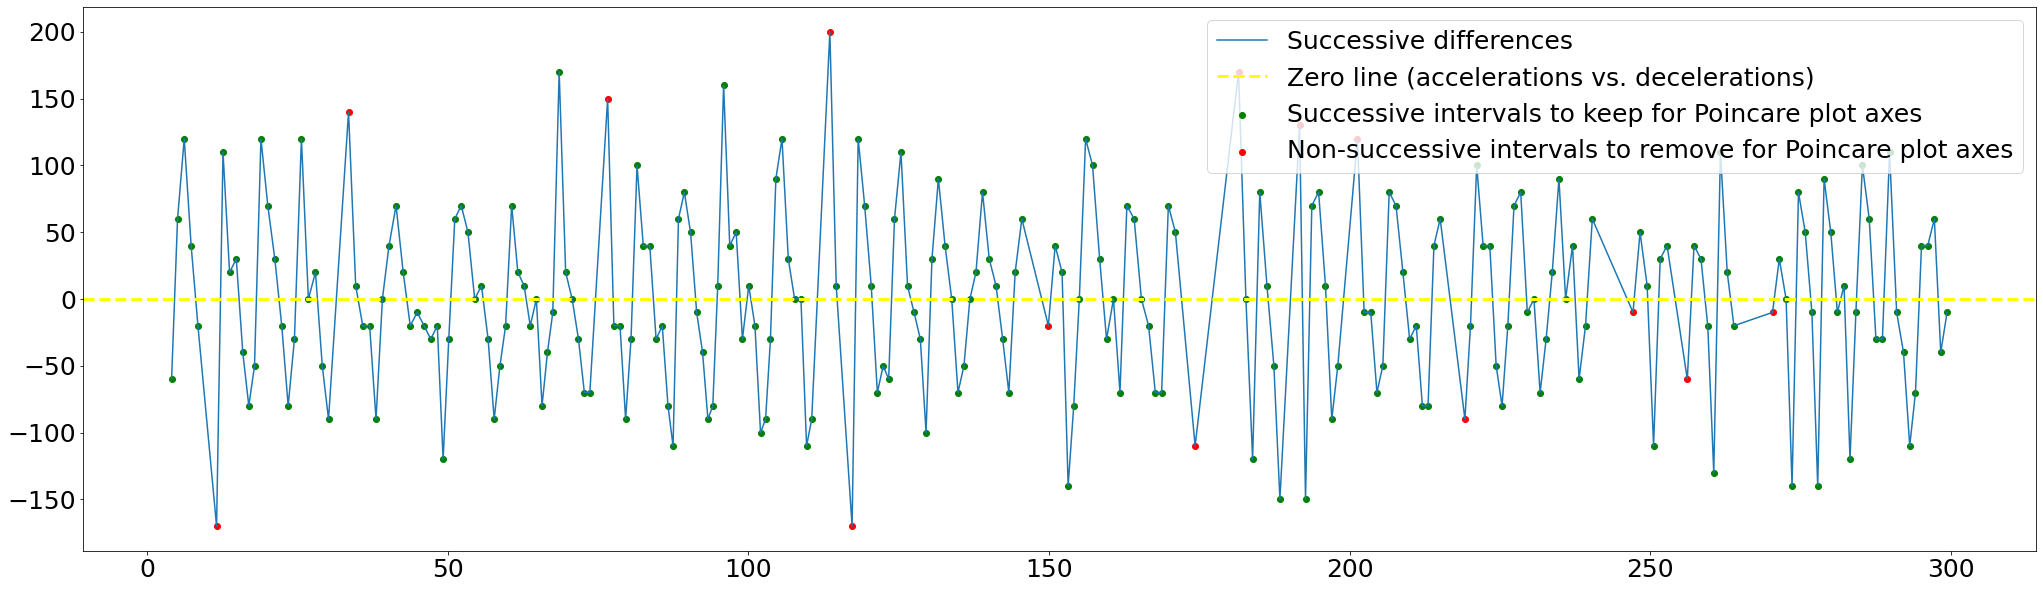

In [23]:
plt.figure()
x = rri[:-1]  # rri_n, x-axis
y = rri[1:]  # rri_plus, y-axis
diff_check_false = y - x

x = x[find_successive_intervals(rri, rri_time)]
y = y[find_successive_intervals(rri, rri_time)]

diff_check_true = y - x

plt.plot(rri_time[1:], diff_check_false)
plt.axhline(
    y=0, xmin=0, xmax=np.max(rri_time), color="yellow", linestyle="--", linewidth=3
)
plt.scatter(
    rri_time[1:][find_successive_intervals(rri, rri_time)],
    diff_check_false[find_successive_intervals(rri, rri_time)],
    c="green",
)
plt.scatter(
    rri_time[1:][np.invert(find_successive_intervals(rri, rri_time))],
    diff_check_false[np.invert(find_successive_intervals(rri, rri_time))],
    c="red"
)


plt.legend(
    [
        "Successive differences",
        "Zero line (accelerations vs. decelerations)",
        "Successive intervals to keep for Poincare plot axes",
        "Non-successive intervals to remove for Poincare plot axes"
    ]
)

plt.show()

In [29]:
def compare_hrv_feats(ecg_data_all, seed, num_seconds=300, sampling_rate=100, ms_threshold=25):
    np.random.seed(seed)
    
    # select a 5 minute segment
    first_sample = np.random.randint(0, len(ecg_data_all) - num_seconds * sampling_rate)
    last_sample = first_sample + num_seconds * sampling_rate
    ecg_clean = np.array(ecg_data_all[first_sample:last_sample])

    # distort the ECG data
    noise_shape = "laplace"
    noise_amplitude = 0.5
    noise_frequency = 5
    powerline_amplitude = 0
    powerline_frequency = 50
    artifacts_amplitude = 2
    artifacts_number = int(np.floor((len(ecg_clean) / sampling_rate) / 5))
    artifacts_frequency = 10
    linear_drift = False

    # create a copy of ECG data
    ecg_noise = ecg_clean.copy()
    ecg_noise = signal_distort(
        ecg_noise,
        sampling_rate=sampling_rate,
        noise_shape=noise_shape,
        noise_amplitude=noise_amplitude,
        noise_frequency=noise_frequency,
        powerline_amplitude=powerline_amplitude,
        powerline_frequency=powerline_frequency,
        artifacts_amplitude=artifacts_amplitude,
        artifacts_frequency=artifacts_frequency,
        artifacts_number=artifacts_number,
        linear_drift=linear_drift,
        random_state=seed,
        silent=False,
    )

    rri_clean, rri_time_clean = ecg_to_cleaned_rri(
        ecg_clean, sampling_rate=sampling_rate, exclude=0
    )
    rri_noise_before_removal, rri_time_noise_before_removal = ecg_to_cleaned_rri(
        ecg_noise, sampling_rate=sampling_rate, exclude=0
    )

    # instead of automatic detection
    # simulate manually cleaned RRI
    # where all RRI that differ from the clean RRI
    # by more than a threshold are removed

    diff_indices = find_diff_from_ref(
        rri_time_clean,
        rri_clean,
        rri_time_noise_before_removal,
        rri_noise_before_removal,
        ms_threshold=ms_threshold,
    )

    rri_noise_after_removal = rri_noise_before_removal[np.invert(diff_indices)]
    rri_time_noise_after_removal = rri_time_noise_before_removal[np.invert(diff_indices)]

    # clean ECG HRV features
    out_clean = hrv(
        rri_clean, rri_time=rri_time_clean, data_format="rri", check_successive=False
    )

    # keep erroneous intervals from noisy ECG
    out_before_removal = hrv(
        rri_noise_before_removal,
        rri_time=rri_time_noise_before_removal,
        data_format="rri",
        check_successive=False,
    )

    # remove erroneous intervals from noisy ECG
    out_include = hrv(rri_noise_after_removal, data_format="rri", check_successive=False)

    # exclude non-successive intervals when computing certain features (e.g. SD1a and GI)
    out_exclude = hrv(
        rri_noise_after_removal,
        rri_time=rri_time_noise_after_removal,
        data_format="rri",
        check_successive=True,
    )

    # get median RR and convert to Hz for interpolation
    median_rri = np.median(rri_noise_after_removal)
    decimals_sampling_rate = 3
    median_rri_sampling_rate = np.round(
        (1 / median_rri) * 1000, decimals=decimals_sampling_rate
    )
    median_bpm = np.round(60000 / median_rri)
    (
        rri_time_noise_after_removal_med,
        rri_noise_after_removal_med,
    ) = resample_with_uneven_times(
        rri_time_noise_after_removal,
        rri_noise_after_removal,
        sampling_rate=median_rri_sampling_rate,
    )
    out_interpl_med = hrv(
        rri_noise_after_removal_med,
        rri_time_noise_after_removal_med,
        data_format="rri",
        check_successive=False,
    )

    # Fixed value (2 Hz) interpolation
    (
        rri_time_noise_after_removal_2hz,
        rri_noise_after_removal_2hz,
    ) = resample_with_uneven_times(
        rri_time_noise_after_removal, rri_noise_after_removal, sampling_rate=2
    )

    out_interpl_2hz = hrv(
        rri_noise_after_removal_2hz,
        rri_time_noise_after_removal_2hz,
        data_format="rri",
        check_successive=False,
    )

    out_all_rri = {
        "Clean": out_clean,
        "Before outlier removal": out_before_removal,
        "Including non-successive intervals": out_include,
        "Excluding non-successive intervals": out_exclude,
        "Median-RR based interpolation": out_interpl_med,
        "2 Hz interpolation": out_interpl_2hz
    }
    
    return out_all_rri

In [31]:
out_list = []
seed_list = list(range(100))
for seed in seed_list:
    print(seed)
    out_list.append(compare_hrv_feats(ecg_data_all, seed, num_seconds=300, sampling_rate=100, ms_threshold=50))

0
1
2
3
4
5
6
7


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8
9


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10
11
12
13
14
15
16
17
18


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19
20
21
22
23


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


24
25
26


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


27
28
29
30
31


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


32
33


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34
35
36
37
38
39
40
41
42
43
44
45
46


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


47
48


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


49
50
51
52
53


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


54
55
56
57
58
59
60
61
62


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


63
64
65
66
67


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


68
69
70
71
72
73
74
75
76
77
78
79


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


80
81
82


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83
84
85


C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\danielle\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [64]:
perc_list_dict = []
for i in range(len(seed_list)):
    seed = seed_list[i]
    out_all_rri = out_list[i]
    feats_to_comp = out_all_rri["Clean"].columns
    for feat_to_comp in feats_to_comp:
        ground_truth = float(out_all_rri["Clean"][feat_to_comp])
        for key in out_all_rri:
            out_feat = float(out_all_rri[key][feat_to_comp])
            perc_change = ((out_feat - ground_truth) / ground_truth) * 100
            perc_list_dict.append({
                "feat": feat_to_comp,
                "method": key,
                "perc_change": perc_change,
                "seed": seed
            })

In [94]:
perc_df = pd.DataFrame(perc_list_dict)
perc_df["abs_perc_change"] = np.abs(perc_df["perc_change"])
perc_df = perc_df[(perc_df["method"]!="Clean")]

In [100]:
perc_df.to_csv("outliers_rri_results.csv")

In [95]:
subset_feats = ["HRV_RMSSD","HRV_SD1a", "HRV_GI"]

In [96]:
mean_abs_perc_df = perc_df.groupby(["feat","method"]).mean()["abs_perc_change"]
mean_abs_perc_df.loc[subset_feats]

feat       method                            
HRV_RMSSD  2 Hz interpolation                    51.617956
           Before outlier removal                76.928161
           Excluding non-successive intervals     1.293474
           Including non-successive intervals     5.504729
           Median-RR based interpolation          4.983183
HRV_SD1a   2 Hz interpolation                    50.661661
           Before outlier removal                77.132911
           Excluding non-successive intervals     2.031289
           Including non-successive intervals     5.704416
           Median-RR based interpolation          3.552377
HRV_GI     2 Hz interpolation                     0.232813
           Before outlier removal                 0.470412
           Excluding non-successive intervals     2.215284
           Including non-successive intervals     0.132448
           Median-RR based interpolation          0.338442
Name: abs_perc_change, dtype: float64

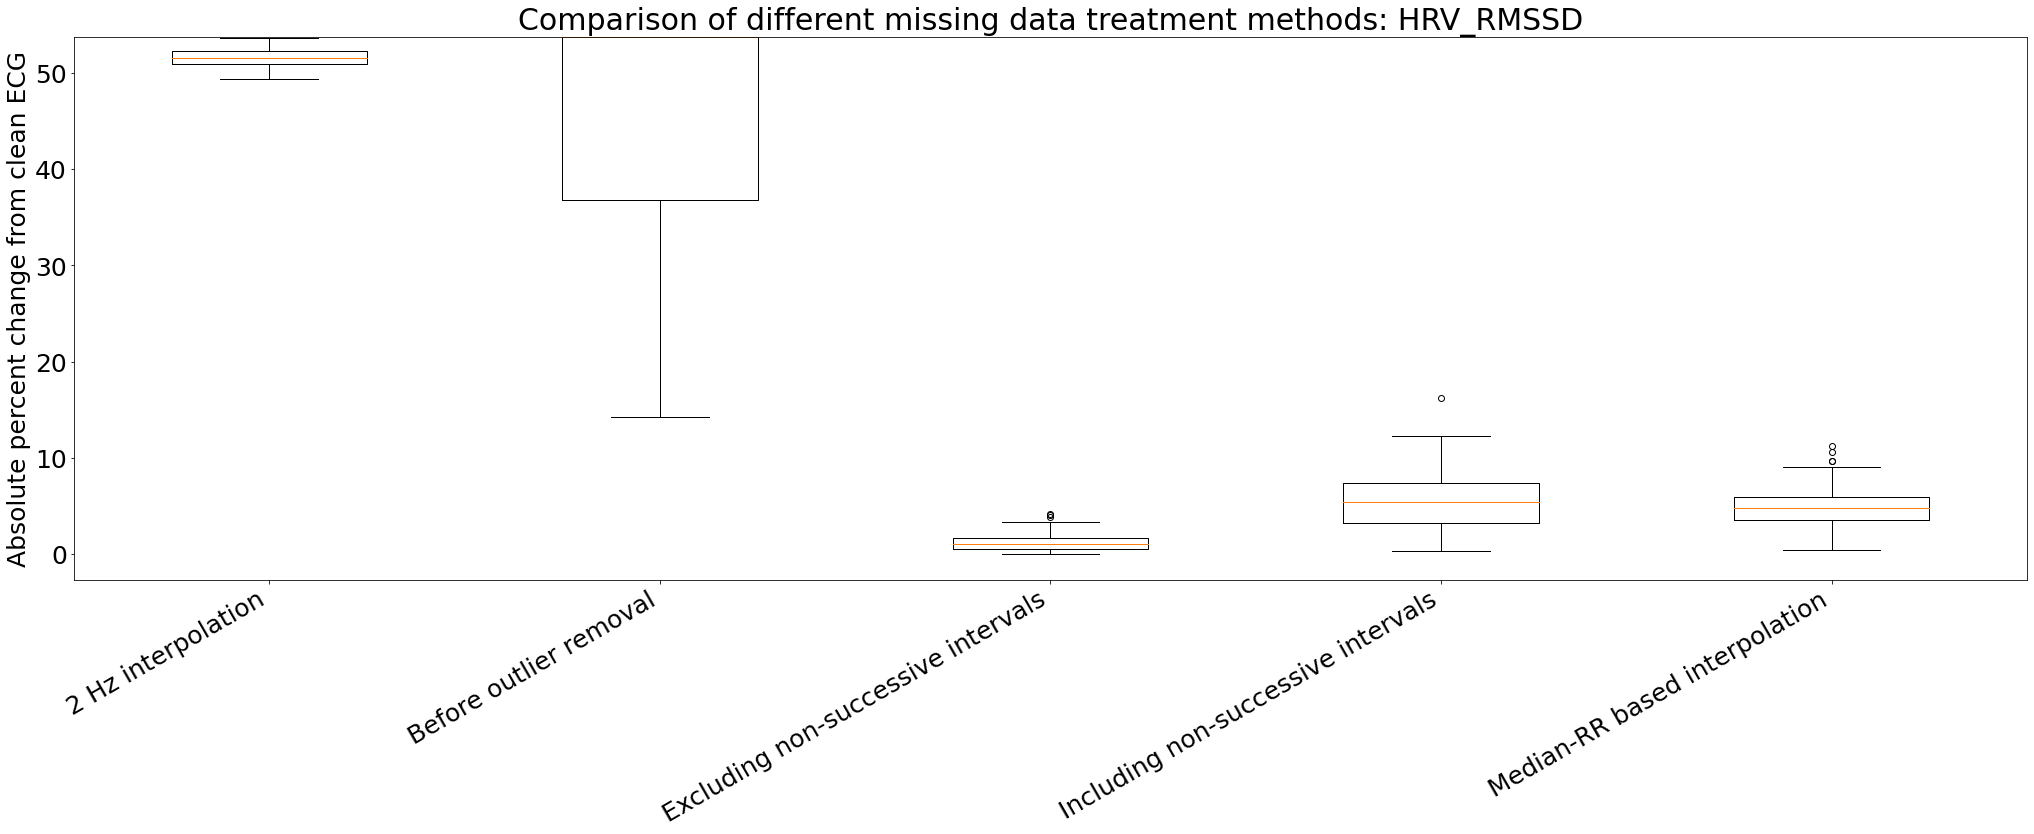

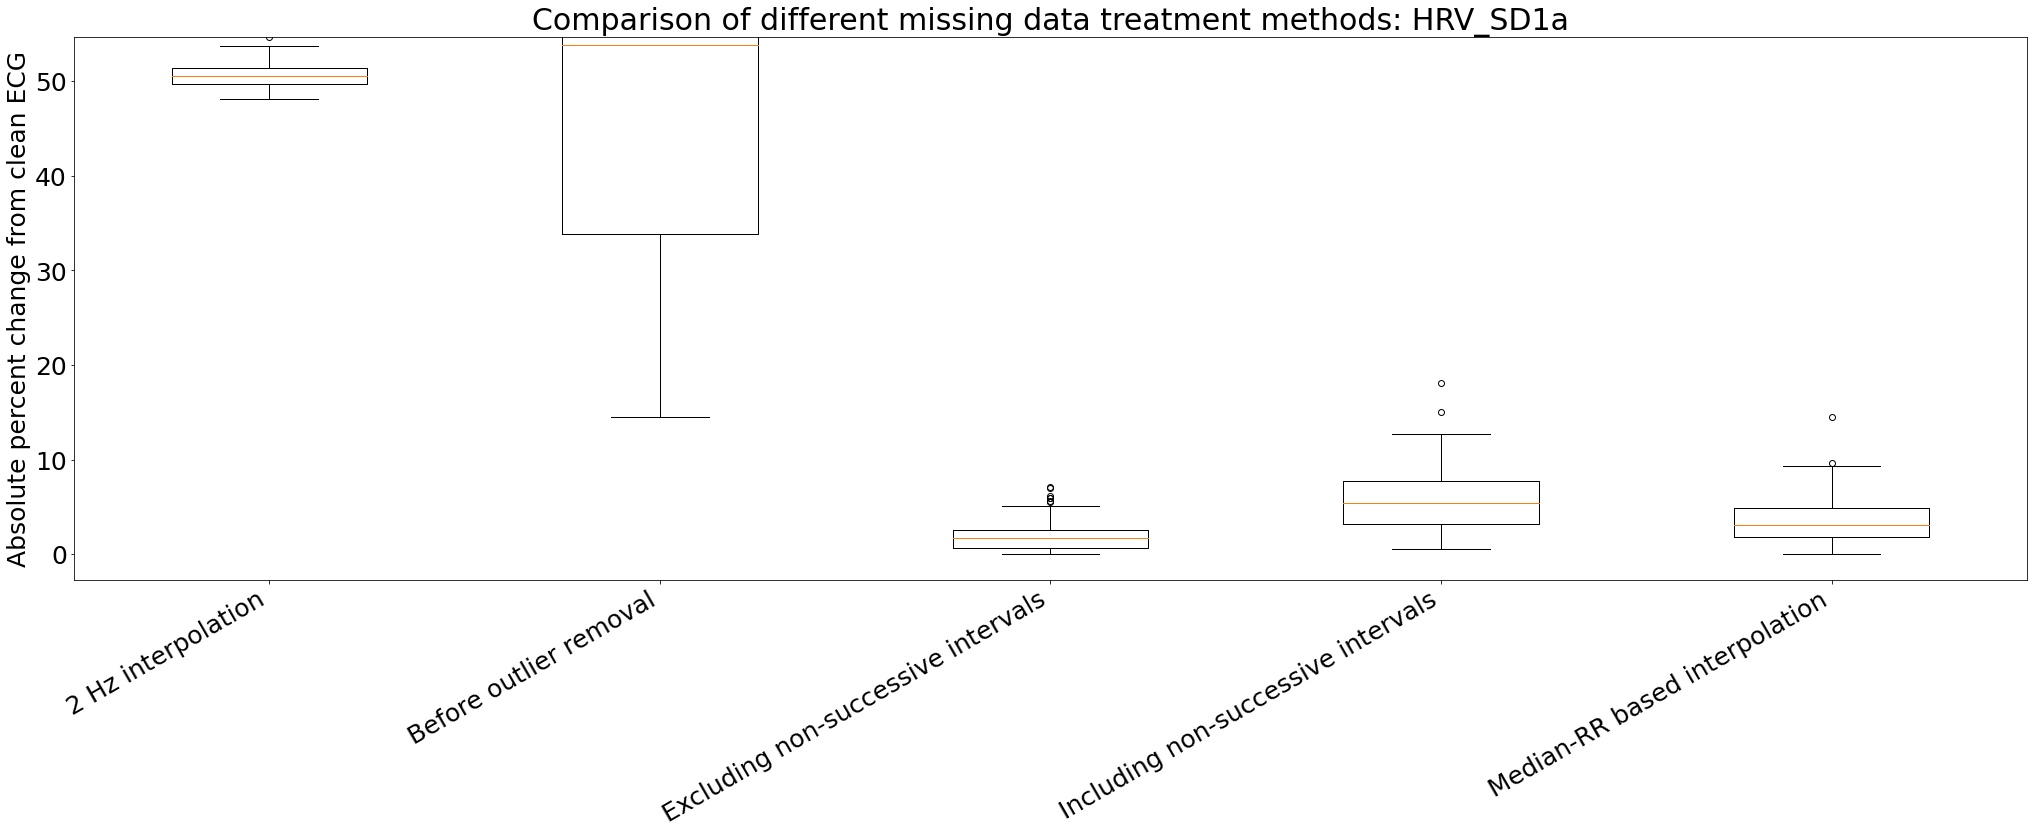

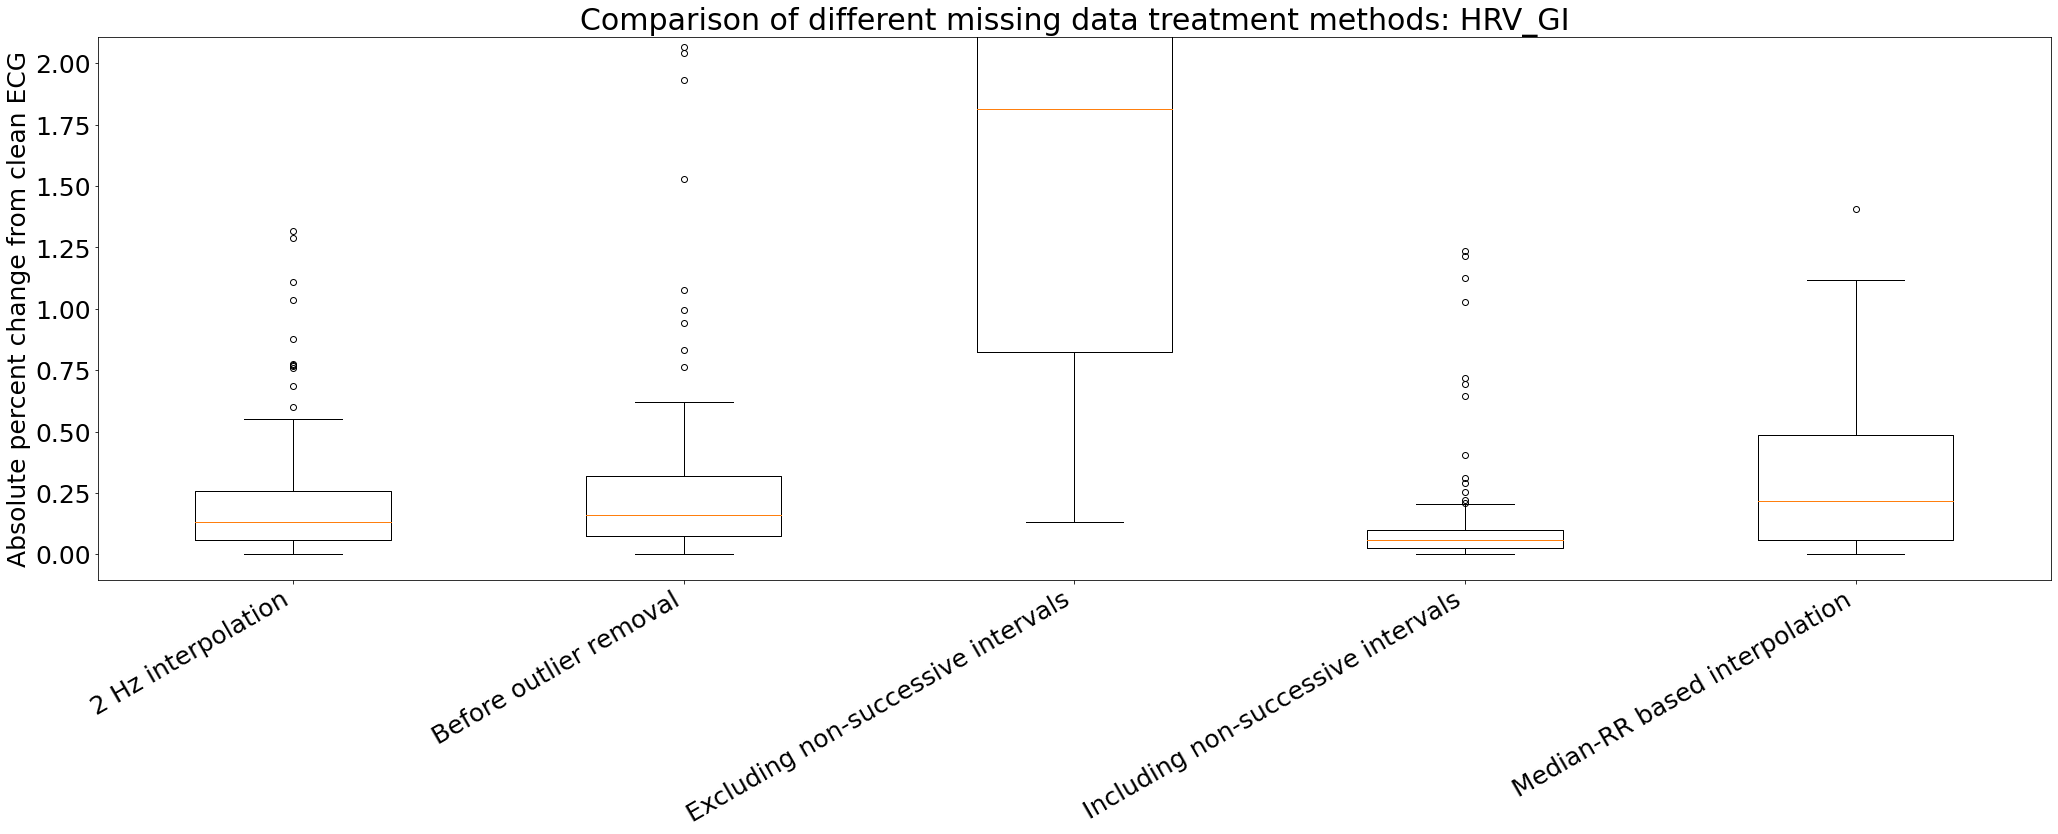

In [99]:
for feat in subset_feats:
    perc_subset = []
    for x in np.unique(perc_df[["method"]].values):
        perc_subset.append(
            perc_df[(perc_df["method"] == x) & (perc_df["feat"] == feat)][
                "abs_perc_change"
            ].values
        )

    fig, axes = plt.subplots()
    axes.boxplot(perc_subset, labels=np.unique(perc_df[["method"]].values))
    plt.setp(axes.get_xticklabels(), rotation=30, horizontalalignment="right")
    plt.ylim([-0.05*np.nanpercentile(perc_subset, 90), np.nanpercentile(perc_subset, 90)])
    plt.ylabel("Absolute percent change from clean ECG")
    plt.title("Comparison of different missing data treatment methods: " + feat)
    plt.show()